extending with: (2, 8) 0


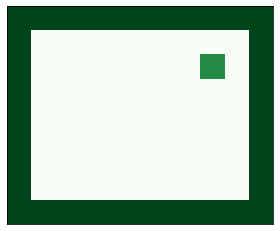

extend: 1


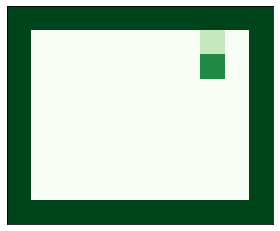

main loop: 2


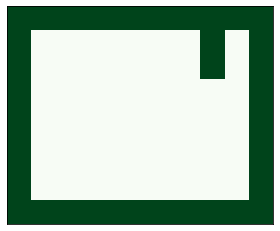

extending with: (4, 8) 3


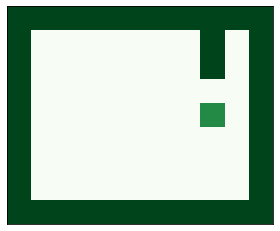

extending with: (6, 8) 4


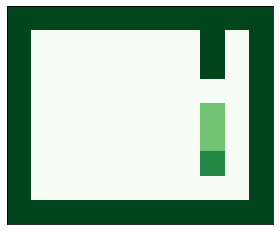

extend: 5


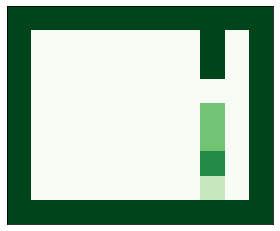

extend: 6


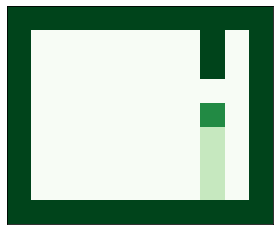

main loop: 7


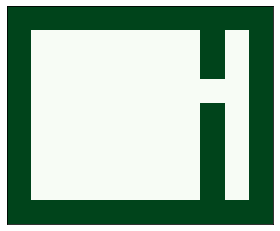

extending with: (2, 2) 8


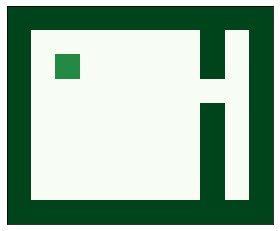

extend: 9


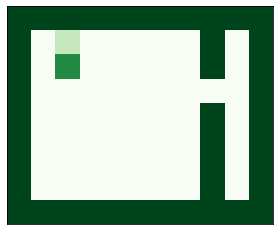

main loop: 10


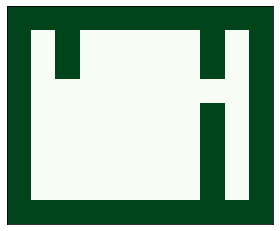

extending with: (4, 6) 11


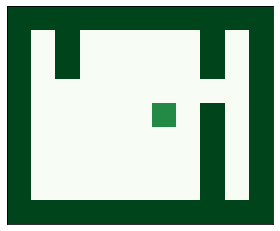

extend: 12


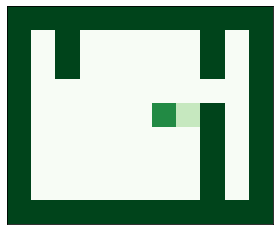

main loop: 13


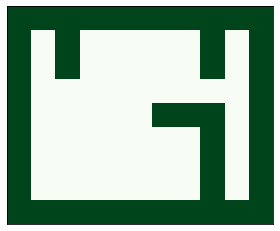

extending with: (2, 4) 14


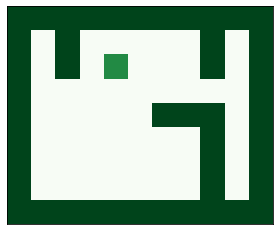

extending with: (4, 4) 15


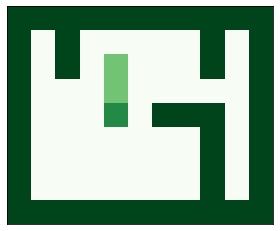

extend: 16


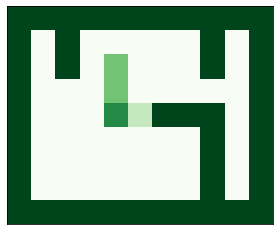

extend: 17


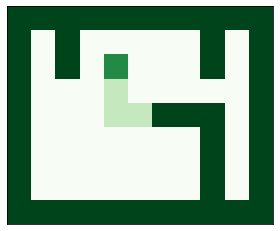

main loop: 18


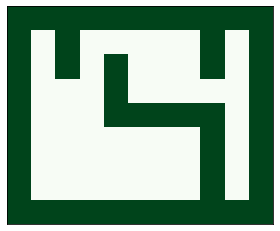

extending with: (6, 6) 19


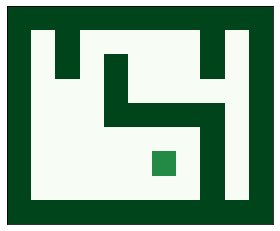

extend: 20


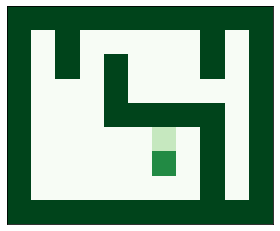

main loop: 21


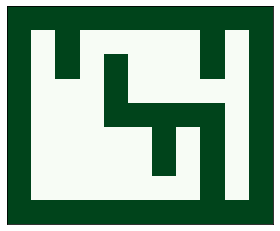

extending with: (6, 2) 22


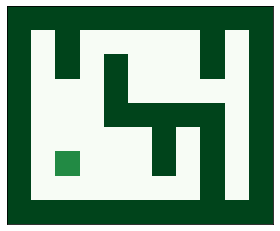

extend: 23


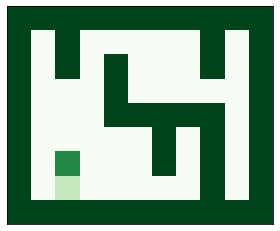

main loop: 24


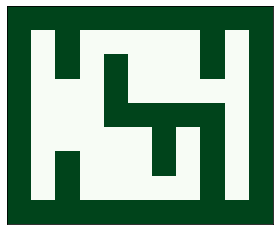

extending with: (4, 2) 25


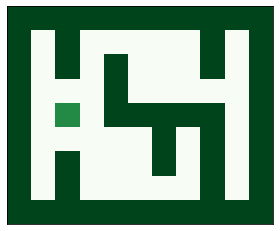

extend: 26


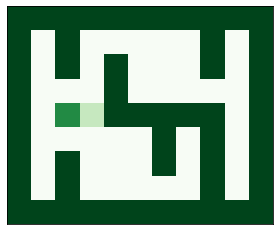

main loop: 27


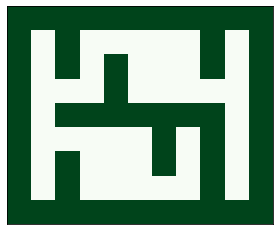

extending with: (2, 6) 28


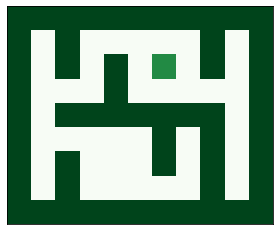

extend: 29


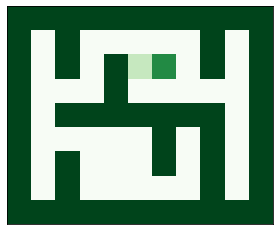

main loop: 30


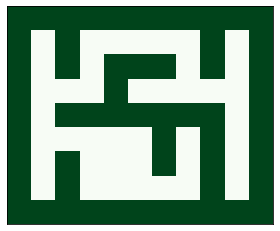

extending with: (6, 4) 31


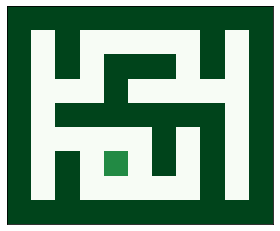

extend: 32


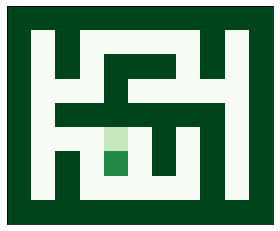

main loop: 33


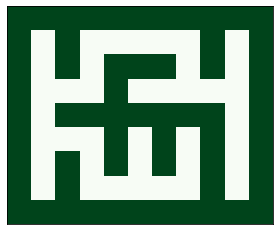

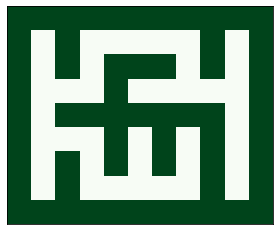

In [3]:
from __future__ import annotations

from enum import Enum
from typing import Union, Generator, NamedTuple, Optional

import matplotlib.pyplot as plt
import numpy as np

index = 0


class Coordinate(NamedTuple):
    """
    2d coordinate index

    Attributes
    ----------
    h : int
        height index
    w : int
        width index
    """
    h: int
    w: int

    def __str__(self):
        return f"({self.h}, {self.w})"

    def __add__(self, other: Coordinate):
        """operator `+`"""
        return Coordinate(self.h + other.h, self.w + other.w)

    def __mul__(self, other: Union[Coordinate, int]):
        """operator `*`"""
        if isinstance(other, int):
            return Coordinate(self.h * other, self.w * other)
        else:
            return Coordinate(self.h * other.h, self.w * other.w)

    def add_mul(self, other: Coordinate, mul: int = 1):
        """
        add coordinates, right term multiplied by mul

        Parameters
        ----------
        self : Coordinate
            left term
        other : Coordinate
            right term
        mul: int, default=1
            right term multiplier

        Returns
        -------
        sum : Coord
            `self + other * mul`
        """
        return Coordinate(self.h + other.h * mul, self.w + other.w * mul)


class Directions(Enum):
    """4 displacements of 2d coordinates"""
    RIGHT = Coordinate(0, 1)
    LEFT = Coordinate(0, -1)
    UP = Coordinate(1, 0)
    DOWN = Coordinate(-1, 0)


def random_maze(
        height: int, width: int,
        random_state: Optional[int] = 42, verbose: int = 0
) -> np.ndarray:
    """
    height x width のランダムな迷路を壁伸ばし法で作成

    Notes
    -----
    参考：https://algoful.com/Archive/Algorithm/MazeExtend

    Parameters
    ----------
    height : int (only odd number)
        盤面の高さ (奇数)
    width : int (only odd number)
        盤面の幅 (奇数)
    random_state: int | None, default=42
        random_state for numpy.random
    verbose : bool, defalt=0
        toggle verbosity
        * 0: no output
        * 1: output text
        * 2: show image
        * 3: show and save image

    Returns
    -------
    maze : ndarray, shape=(height, width), dtype=int
        生成された迷路（壁=1, 道=0）

    Raises
    ------
    ValueError
        * if height or width is not odd
    """
    global index
    if not(height % 2 == 1 and width % 2 == 1):
        raise ValueError(
            f"maze size must be (odd, odd) but input is ({height}, {width})")
    np.random.seed(random_state)
    # 最外周だけ壁にする
    maze: np.ndarray = np.zeros((height, width), dtype=int)
    maze[0, :] = 1
    maze[-1, :] = 1
    maze[:, 0] = 1
    maze[:, -1] = 1

    while True:
        # 始点となりうる点を検索
        candidates: list[Coordinate] = []
        for h in range(0, height, 2):
            for w in range(0, width, 2):
                if maze[h, w] == 0:
                    candidates.append(Coordinate(h, w))
        # 偶数座標が埋まりきっていれば終了
        if candidates == []:
            break

        # 始点から始めて既存の壁に到達するまで壁を伸ばす
        start = candidates[np.random.randint(len(candidates))]
        err, builded = extend_wall(maze, start, [start], verbose)
        assert err == 1, "hoge"
        for cood in builded:
            maze[cood] = 1

        if verbose > 0:
            print("main loop:", index)
        if verbose > 1:
            # 生成途中の図を出力
            show_maze(maze)
            if verbose > 2:
                # 図を保存
                plt.savefig(f"img{index:04}.png")
            plt.show()
        index += 1
    return maze


def extend_wall(
        maze: np.ndarray, curr: Coordinate,
        building: list[Coordinate],
        verbose: int = 0
) -> tuple[int, list[Coordinate]]:
    """
    始点から始めて既存の壁に到達するまで壁を伸ばす

    Parameters
    ----------
    maze : ndarray, shape=(height, width), dtype=int
        現時点での迷路
    curr : Coordinate
        始点
    building : list[Coordinate]
        生成中の座標リスト
    verbose : bool, defalt=0
        toggle verbosity
        * 0: no output
        * 1: output text
        * 2: show image
        * 3: show and save image

    Returns
    -------
    err : int
        壁を生成できたら 1，行き止まりなら -1
    builded : list[Coordinate]
        始点から既存の壁にたどり着くまでに新たに作った壁の座標リスト
    """
    global index
    # 進める方向をランダムに選び，2マスずつ進む．
    # 既存の壁にたどり着いたら完了
    # 自分にぶつかるようなら戻ってやり直す
    if verbose > 0:
        print("extending with:", curr, index)
    if verbose > 1:
        # 生成途中の図を出力
        maze2: np.ndarray = maze.copy().astype(float)
        for pos in building:
            maze2[pos] = 0.5
        maze2[curr] = 0.75
        show_maze(maze2)
        if verbose > 2:
            # 図を保存
            plt.savefig(f"img{index:04}.png")
        plt.show()
    
    index += 1
    *dirs, = search_acceptable_dir(maze, curr, building)
    if dirs == []:
        err, builded = -1, building
    else:
        n = len(dirs)
        for idir in np.random.choice(range(n), n, False):
            # 次に進む方向を進める中からランダムに決める
            dir = dirs[idir]
            next = curr.add_mul(dir, 2)
            if maze[next] == 1:
                # 2つ進んだ先が既存の壁なら生成を完了して返す
                err, builded = (1, building+[curr+dir])
                break
            else:
                # 2つ先が空いた空間なら生成を続ける
                err, builded = extend_wall(
                    maze, next, building+[curr+dir, next], verbose)
                if err == 1:
                    break
        else:
            err, builded = (-1, building)

    if verbose > 0:
        print("extend:" if err == 1 else "back:", index)
    if verbose > 1:
        # 生成途中の図を出力
        maze2: np.ndarray = maze.copy().astype(float)
        if err == 1:
            for pos in builded:
                maze2[pos] = 0.25
            for pos in building:
                maze2[pos] = 0.5
            maze2[curr] = 0.75
        else:
            for pos in builded:
                maze2[pos] = 0.5
            maze2[curr] = 0.75
        show_maze(maze2)
        if verbose > 2:
            # 図を保存
            plt.savefig(f"img{index:04}.png")
        plt.show()
    index += 1
    return (err, builded)


def search_acceptable_dir(
        maze: np.ndarray, curr: Coordinate,
        building: list[Coordinate]
) -> Generator[Coordinate, None, None]:
    """
    以下の条件を満たす方向を探す
    * 進んだ先が既存の壁ではない
    * 進んだ先が生成中の壁ではない
    * 2つ進んだ先が生成中の壁ではない

    Parameters
    ----------
    maze : ndarray, shape=(height, width)
        これまでに生成された壁が記録されたmap
    curr : Coordinate
        現在の座標
    building : list[Coordinate]
        生成途中の座標リスト

    Yields
    ------
    dir : Coordinate
        次の行き先として適切な方向
    """
    for dir in Directions:
        if maze[curr + dir.value] == 0\
                and curr + dir.value not in building\
                and curr.add_mul(dir.value, 2) not in building:
            yield dir.value


def show_maze(
        maze: Optional[np.ndarray] = None,
        height: int = 7, width: int = 9,
        random_state: Optional[int] = None,
        cmap: str = 'Greens',
        verbose: int = 0
):
    """
    set parameters and show image of maze

    Parameters
    ----------
    maze : ndarray, optional, default=None
    height : int
    width : int
    random_state : int, optional, default=None
    cmap : str, default='Greens'
    verbose : bool, defalt=0
        toggle verbosity
        * 0: no output
        * 1: output text
        * 2: show image
        * 3: show and save image
    """
    if maze is None:
        maze = random_maze(height, width, random_state, verbose)
    plt.rcParams['image.cmap'] = cmap
    plt.tick_params(labelbottom=False, labelleft=False, labelright=False,
                    labeltop=False, bottom=False, left=False, right=False, top=False)
    plt.imshow(maze)


show_maze(None, 9, 11, 5, verbose=2)
plt.show()